In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from matplotlib.colors import ListedColormap
from matplotlib.dates import DateFormatter, ConciseDateFormatter, DayLocator, HourLocator
from matplotlib import rc
rc('animation', html='jshtml')
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import time
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import os
drive._mount('/content/drive')
%matplotlib inline

Mounted at /content/drive


# Leitura dos dados

In [ ]:
pref = 'drive/MyDrive/Colab Data/PdM_'
suf = '.csv'
telemetry = pd.read_csv(f'{pref}telemetry{suf}', parse_dates=['datetime'])
errors = pd.read_csv(f'{pref}errors{suf}', parse_dates=['datetime'])
failures = pd.read_csv(f'{pref}failures{suf}', parse_dates=['datetime'])
machines = pd.read_csv(f'{pref}machines{suf}')
maint = pd.read_csv(f'{pref}maint{suf}', parse_dates=['datetime'])

dfs = [errors, failures]
dfs_cols = ['errorID', 'failure']

In [ ]:
data = telemetry
for df in dfs:
  data = pd.merge(data, df, how='outer', on=['datetime', 'machineID'])

In [ ]:
def convertData(val):
  """
  Convert de column value to str value
  - NA/NaN/inf returns 0
  - else returns last character
  """
  if str(val) == 'nan':
    new_val = '0'
  else:
    new_val = str(val)[-1]
  return str(new_val)

In [ ]:
for col in dfs_cols:
  data[col] = data[col].apply(convertData)
  data[col] = data[col].astype('str')

data = data.dropna()
data.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
errorID              object
failure              object
dtype: object

In [ ]:
# for index, row in data.iterrows():
#   if row.failure == "0":
#     if row.errorID != "0":
#       data.loc[index, 'failure'] = row.errorID

In [ ]:
# Retirando as máquinas que não apresentaram falhas no período
ids = []
for id in data.machineID.unique():
  temp_data = data[data.machineID == id]
  if len(temp_data[temp_data.failure != "0"]) < 1:
    data = data[data.machineID !=  id]
    ids.append(id)
print(f'IDs de máquinas retiradas: {ids}')

IDs de máquinas retiradas: [6, 77]


# Divisão dos dados
> Divisão de todos os dados em datasets balanceados com 2 classes cada um em relação à quantidade de dias para falha. (30, 15, 7, 3.5, 2, 1) 



In [ ]:
# Dividir em duas classes
# #  Mais de 30 dias
# #  Menos de 30 dias
class_over30 = "> 30 dias"
class_under30 = "< 30 dias"
data['30dias'] = class_over30
for index, row in data[data.failure != '0'].iterrows():
  data.loc[index-30*24:index, '30dias'] = class_under30


In [ ]:
# Dividir em mais duas classes
# # Menos de 15 dias
# # Mais de 15 dias
class_under15 = '< 15 dias'
class_over15 = '> 15 dias'
data["15dias"] = class_over15
for index, row in data[data.failure != '0'].iterrows():
  start = index-(15*24)
  data.loc[start:index, '15dias'] = class_under15


In [ ]:
# Dividir em mais duas classes
# # Menos de 7 dias
# # Mais de 7 dias
class_under7 = '< 7 dias'
class_over7 = '> 7 dias'
data["7dias"] = class_over7
for index, row in data[data.failure != '0'].iterrows():
  data.loc[index-7*24:index, '7dias'] = class_under7

In [ ]:
# Dividir em mais duas classes
# # Menos de 3.5 dias
# # Mais de 3.5 dias
class_under4 = '< 4 dias'
class_over4 = '> 4 dias'
data["4dias"] = class_over4
for index, row in data[data.failure != '0'].iterrows():
  data.loc[index-4*24:index, '4dias'] = class_under4

In [ ]:
# Dividir em mais duas classes
# # Menos de 2 dias
# # Mais de 2 dias
class_under2 = '< 2dias'
class_over2 = '> 2dias'
data["2dias"] = class_over2
for index, row in data[data.failure != '0'].iterrows():
  data.loc[index-2*24:index, '2dias'] = class_under2

In [ ]:
# # Separando os dados em duas classes somente por dado

# data30 = data.drop(columns=['15dias', '7dias', '4dias', '2dias'])
# data15 = data.loc[data['30dias']  == class_under30].drop( columns=['30dias', '7dias', '4dias', '2dias'])
# data7 = data.loc[data['15dias']   == class_under15].drop( columns=['30dias', '15dias', '4dias', '2dias'])
# data4 = data.loc[data['7dias']  == class_under7].drop(  columns=['30dias', '15dias', '7dias', '2dias'])
# data2 = data.loc[data['4dias']  == class_under4].drop(columns=['30dias', '15dias', '7dias', '4dias'])

In [ ]:
# data2['2dias'].value_counts(normalize=True)

In [ ]:
# filter = (data['2dias'] == '> 2dias')
# data_filtered = data[filter]
# for col in ['vibration', 'rotate', 'volt', 'pressure']:
#   Q1 = data_filtered[col].quantile(0.15)
#   Q3 = data_filtered[col].quantile(0.85)
#   IQR = Q3 - Q1
#   print(col)
#   print(Q1-IQR)
#   print(Q3+IQR)

#   filter_col = (data_filtered[col] >= Q1 - IQR) & (data_filtered[col] <= Q3 + IQR)
#   data_filtered = data_filtered[filter_col]

# data_filtered = data_filtered.append(data[data['2dias'] == '< 2dias'])
# data_filtered = data_filtered.sort_values(by='datetime')
data_filtered = data

# Criando novos features


> Volt, Vibration, Pressure and Rotation **mean last 24h**

> Volt, Vibration, Pressure and Rotation **mean last 2d**

> Volt, Vibration, Pressure and Rotation **max last 2d**

> Volt, Vibration, Pressure and Rotation **min last 2d**


In [ ]:
# errorCondition = data.errorID == '0'
# data[errorCondition].failure.value_counts()
# data = data[errorCondition]
# data
mean_val = 0.5
24//mean_val

48.0

In [ ]:
# executa em 3s para 876445 linhas
features_cols = ['volt', 'vibration', 'rotate', 'pressure']
mean_suf24 = '_mean24h'
sd_suf24 = '_std24h'
mean_suf2 = '_mean12h'
sd_suf2 = '_std12h'
max_suf2 = '_max_6h'
min_suf2 = '_min_6h'

for id in data_filtered.machineID.unique():
  for col in features_cols:
    data_filtered.loc[data_filtered.machineID == id, f'{col}_ewma24h'] = data_filtered.loc[data_filtered.machineID == id, col].ewm(span=24).mean()
    data_filtered.loc[data_filtered.machineID == id, f'{col}{mean_suf24}'] = data_filtered.loc[data_filtered.machineID == id, col].rolling(24).mean()
    # data_filtered.loc[data_filtered.machineID == id, f'{col}{sd_suf24}'] = data_filtered.loc[data_filtered.machineID == id, col].rolling(24).std()
    # data_filtered.loc[data_filtered.machineID == id, f'{col}{mean_suf2}'] = data_filtered.loc[data_filtered.machineID == id, col].rolling(int(24/mean_val)).mean()
    # data_filtered.loc[data_filtered.machineID == id, f'{col}{sd_suf2}'] = data_filtered.loc[data_filtered.machineID == id, col].rolling(int(24/mean_val)).std()
    # data_filtered.loc[data_filtered.machineID == id, f'{col}{max_suf24}'] = data_filtered.loc[data_filtered.machineID == id, col].rolling(24).max()
    data_filtered.loc[data_filtered.machineID == id, f'{col}{max_suf2}'] = data_filtered.loc[data_filtered.machineID == id, col].rolling(int(6)).max()
    data_filtered.loc[data_filtered.machineID == id, f'{col}{min_suf2}'] = data_filtered.loc[data_filtered.machineID == id, col].rolling(int(6)).min()
    # data_filtered.loc[data_filtered.machineID == id, 'RUL'] = data_filtered.loc[data_filtered.machineID == id].groupby((data_filtered.failure != data_filtered.failure.shift()).cumsum()).cumcount(ascending=False)
# data_filtered.drop(columns = features_cols)
data_filtered = data_filtered.dropna()
# data_filtered['RUL'] = data_filtered['RUL'].astype('int')


In [ ]:
# data['Problem'] = 0

# for index, row in data.iterrows():
#   if row.failure != '0':
#     for i in range(0,49):
#       data.loc[index-i, 'Problem'] = 1


In [ ]:
sim_machines = data_filtered[data_filtered.machineID > 95]
data_filtered = data_filtered[data_filtered.machineID < 96]

In [ ]:
# plt.figure(figsize=(20,10))
# # sns.lineplot(data=data[data.machineID == 42][:481], x='datetime', y='volt_mean24h')
# # sns.lineplot(data=data[data.machineID == 42][:481], x='datetime', y='volt_mean2d')
# # sns.lineplot(data=data[data.machineID == 42][:481], x='datetime', y='volt')
# sns.scatterplot(data=data[data.machineID == 42][:1500], x='datetime',y='volt_mean2d', hue='failure', sizes=(250,1500))

In [ ]:
# Separando os dados em duas classes somente por dado
data30 = data_filtered.drop(columns=['15dias', '7dias', '4dias', '2dias'])
data15 = data_filtered.loc[data_filtered['30dias']  == class_under30].drop( columns=['30dias', '7dias', '4dias', '2dias'])
data7 = data_filtered.loc[data_filtered['15dias']   == class_under15].drop( columns=['30dias', '15dias', '4dias', '2dias'])
data4 = data_filtered.loc[data_filtered['7dias']  == class_under7].drop(  columns=['30dias', '15dias', '7dias', '4dias'])
data2 = data_filtered.loc[data_filtered['4dias']  == class_under4].drop(columns=['30dias', '15dias', '7dias', '4dias'])

In [ ]:
data_filtered.to_pickle('/content/data_filtered')

# Formatação de gráficos para o formato científico

In [ ]:
%%bash
git clone https://github.com/garrettj403/SciencePlots.git
cd SciencePlots
pip install -e .

Obtaining file:///content/SciencePlots
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Running setup.py develop for SciencePlots


Cloning into 'SciencePlots'...


In [ ]:
data_filtered.to_pickle('data')

In [ ]:
!pip install latex

  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7606 sha256=7933df6a92afdf4a332cf1f9e78f427503433d94309a173c0ceef75f7bbbbc7f
  Stored in directory: /root/.cache/pip/wheels/57/d6/11/5d5718227890d9e479b6137cb406410c37a0b84b2ab35b872b
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7245 sha256=e4f3feaad6aa12fd82e85512dec46dd0f4c6953a2412ad05eccfdf8aaa08f600
  Stored in directory: /root/.cache/pip/wheels/28/76/4b/7db27e02c1de4d2181559d108fcdfed1680ff7d3534553d460
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2782 sha256=a12f9451515cd672b5c5585f48993a3f04d41a8a950625cab49b14adb86fbad7
  Stored in directory: /root/.cache/pip/wheels/4c/c0/ce/5a47f35186acbe73e38811df30daaf798c81a7599bb2d5995a
  Created wheel for tempdir: filename=tempdir-0.7.1-py3-none-any.whl size=2213 sha256=b6da5a43afb3090424f172bd8e6d75019535c21f3616b7197317b3255d134872
  Stored in directory: /root/.cache/pip/wheels/7a/f1/d7/124b54c21a9ba4973bc60fc

In [ ]:
plt.style.reload_library()
plt.style.use(['science', 'notebook', 'grid', 'no-latex'])
# plt.rcParams.update({
#     "font.family": "Times New Roman",   # specify font family here
#     "font.serif": ["Times"],  # specify font here
#     "font.size":10})          # specify font size here



# Pré processamento dos dados

In [ ]:
data2.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'errorID', 'failure', '2dias', 'volt_ewma24h', 'volt_mean24h',
       'volt_max_6h', 'volt_min_6h', 'vibration_ewma24h', 'vibration_mean24h',
       'vibration_max_6h', 'vibration_min_6h', 'rotate_ewma24h',
       'rotate_mean24h', 'rotate_max_6h', 'rotate_min_6h', 'pressure_ewma24h',
       'pressure_mean24h', 'pressure_max_6h', 'pressure_min_6h'],
      dtype='object')

In [ ]:
Two_days_col = data2['2dias']
data2 = data2.drop(columns=['2dias'])
data2['2dias'] = Two_days_col

In [ ]:
data2['2dias'].value_counts(normalize=True)

< 2dias    0.504177
> 2dias    0.495823
Name: 2dias, dtype: float64

In [ ]:
# Leu os dados da base?
# data_list = [all_data['data2']]
# Executou os scripts?
data_list = [data2]

x_train_list = []
x_test_list = []
y_train_list = []
y_test_list = []
scaler_list = []
encoder_list = []
for dataset in data_list:
  scaler = MinMaxScaler()
  le = LabelEncoder()
  # temp_data = dataset.drop(columns = ['datetime', 'errorID', 'failure', 'machineID', 'RUL']).to_numpy()
  temp_data = dataset.drop(columns = ['datetime', 'errorID', 'failure', 'machineID'] + features_cols)
  temp_data = temp_data.to_numpy()
  scaler.fit(temp_data[:, :-1])
  temp_scaled_data = scaler.transform(temp_data[:, :-1])
  x_train, x_test, y_train, y_test = train_test_split(temp_scaled_data, temp_data[:, -1])
  print(x_train.shape)
  le.fit(y_train)
  x_train_list.append(x_train)
  x_test_list.append(x_test)
  y_train_list.append(le.transform(y_train))
  y_test_list.append(le.transform(y_test))
  scaler_list.append(scaler)
  encoder_list.append(le)

(48300, 16)


In [ ]:
data2['2dias'].value_counts(normalize=True)

< 2dias    0.504177
> 2dias    0.495823
Name: 2dias, dtype: float64

In [ ]:
scaler_list

[MinMaxScaler()]

In [ ]:
x_train_list[0]

array([[0.20392314, 0.22160966, 0.38372181, ..., 0.16884486, 0.24274535,
        0.33658056],
       [0.34347902, 0.32158561, 0.33708716, ..., 0.18055193, 0.31197301,
        0.31713185],
       [0.28341986, 0.28853474, 0.31461711, ..., 0.13355536, 0.21293822,
        0.22104768],
       ...,
       [0.20656407, 0.17472741, 0.32749821, ..., 0.14324586, 0.20132486,
        0.39730873],
       [0.28158765, 0.29382656, 0.38433397, ..., 0.14925503, 0.11120947,
        0.3554598 ],
       [0.12402803, 0.14578521, 0.25147371, ..., 0.30063601, 0.54472488,
        0.4993974 ]])

# Validação Cruzada

In [ ]:

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
splits = list(kfold.split(x_train_list[0]))
train_indices = splits[0][0]

In [ ]:
class ComputationalEffortHistory(keras.callbacks.Callback):
  def __init__(self, model_number):
    self.logs = []
    self.model_number = model_number

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(time.time() - self.epoch_time_start)


In [ ]:
cross_epochs = 30
cross_batch_size = 30
print(f'Epochs: {cross_epochs}\nBatch Size: {cross_batch_size}')

models_1esc = []
models_2esc = []
computational_effort = []
nodes1 = list(range(4, 17, 4))
nodes2 = list(range(2, 9, 2))
for i, item in enumerate(nodes1):
  
  models_1esc.append(
      Sequential(
          [
            Dense(item, activation='sigmoid', input_shape=(x_train_list[0].shape[1], )),
            Dense(1, activation='sigmoid')
          ]
      )
  )
  models_2esc.append(
      Sequential(
          [
            Dense(item, activation='sigmoid', input_shape=(x_train_list[0].shape[1], )),
            Dense(nodes2[i], activation='sigmoid'),
            Dense(1, activation='sigmoid')
          ]
      )
  )

models = models_1esc + models_2esc

history_list = []

for index, model in enumerate(models):

  timing_callback = ComputationalEffortHistory(index)
  computational_effort.append(timing_callback)

  model.compile(
      optimizer='adam',
      metrics=['accuracy'],
      loss='binary_crossentropy',
  )

  history_list.append(
      model.fit(
        x_train_list[0][train_indices],
        y_train_list[0][train_indices],
        batch_size=cross_batch_size,
        epochs=cross_epochs,
        validation_data=(x_test_list[0], y_test_list[0]),
        callbacks=[timing_callback]
        )
  )

In [ ]:
for model in models:
  model.summary()

In [ ]:
legend = []
for i, model in enumerate(models):
  if i < 4:
    legend.append(str([16, nodes1[i], 1]))
  else:
    legend.append(str([16, nodes1[i-4], nodes2[i-4], 1]))

print(legend)

['[16, 4, 1]', '[16, 8, 1]', '[16, 12, 1]', '[16, 16, 1]', '[16, 4, 2, 1]', '[16, 8, 4, 1]', '[16, 12, 6, 1]', '[16, 16, 8, 1]']


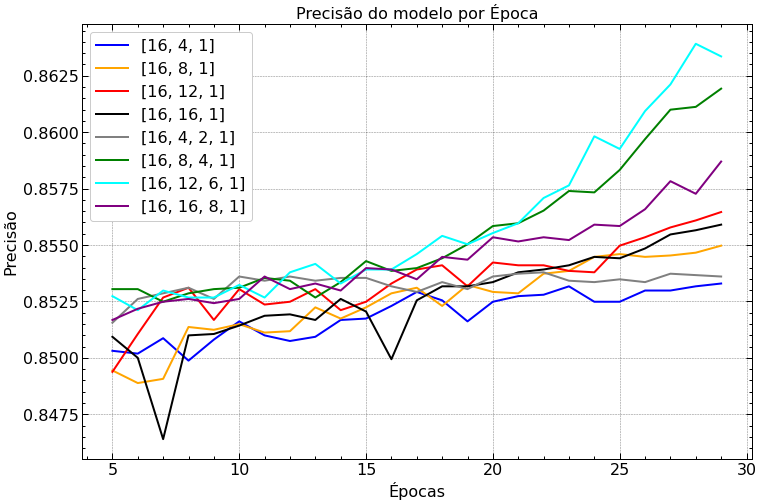

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title('Precisão do modelo por Época')
ax.set_ylabel('Precisão')
ax.set_xlabel('Épocas')
colors = ['blue', 'orange', 'red', 'black', 'grey', 'green', 'cyan', 'purple']

# ax.legend(['', 'val'], loc='upper left')
for index, history in enumerate(history_list):
  # ax.plot(history.history['val_loss'])
  ax.plot(history.epoch[5:], history.history['val_accuracy'][5:], color=colors[index])

# ax.legend([str([16,12,1]), str([16,12,6,1])])
ax.legend(legend)
plt.plot()
fig.savefig('/content/cross_validation_accuracy_zoom.png')

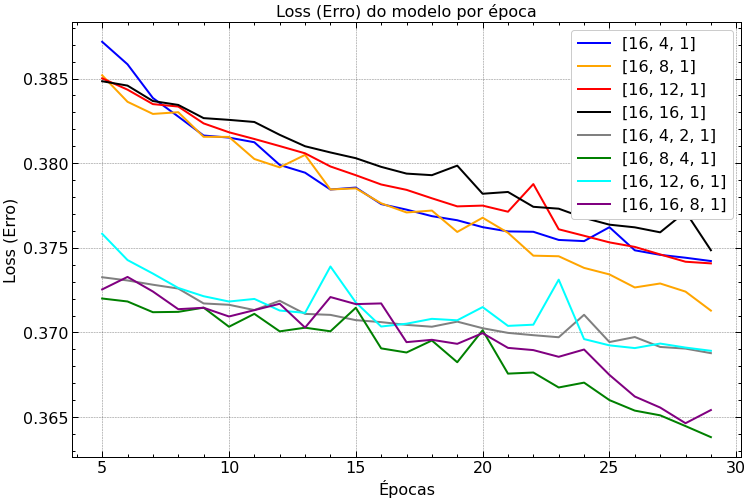

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title('Loss (Erro) do modelo por época')
ax.set_ylabel('Loss (Erro)')
ax.set_xlabel('Épocas')
colors = ['blue', 'orange', 'red', 'black', 'grey', 'green', 'cyan', 'purple']


# ax.legend(['', 'val'], loc='upper left')
for index, history in enumerate(history_list):
  # ax.plot(history.history['val_loss'])
  ax.plot(history.epoch[5:], history.history['val_loss'][5:], color=colors[index])

# ax.legend([str([16,12,1]), str([16,12,6,1])])
ax.legend(legend)
plt.plot()
fig.savefig('/content/cross_validation_loss_zoom.png')

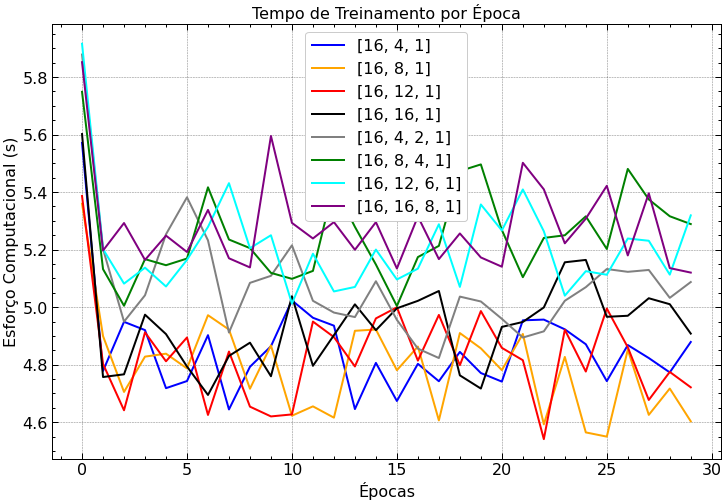

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title('Tempo de Treinamento por Época')
ax.set_ylabel('Esforço Computacional (s)')
ax.set_xlabel('Épocas')
colors = ['blue', 'orange', 'red', 'black', 'grey', 'green', 'cyan', 'purple']

# ax.legend(['', 'val'], loc='upper left')
for index, history in enumerate(history_list):
  # ax.plot(history.history['val_loss'])
  ax.plot(history.epoch, computational_effort[index].logs, color=colors[index])

# ax.legend([str([16,12,1]), str([16,12,6,1])])
ax.legend(legend)
plt.plot()
fig.savefig('/content/cross_validation_computational_effort.png')

# Treinamento dos melhores modelos

In [ ]:
final_models = [
  
  Sequential(
      [
        Dense(16, activation='sigmoid', input_shape=(x_train_list[0].shape[1], )),
        Dense(1, activation='sigmoid')
      ]
  ),
  Sequential(
      [
        Dense(12, activation='sigmoid', input_shape=(x_train_list[0].shape[1], )),
        Dense(6, activation='sigmoid'),
        Dense(1, activation='sigmoid')
      ]
  )
]
final_history = []
final_computational_effort = []

for i, model in enumerate(final_models):

  final_timing_callback = ComputationalEffortHistory(i)
  final_computational_effort.append(final_timing_callback)

  model.compile(
    optimizer='adam',
    metrics=['accuracy'],
    loss='binary_crossentropy'
  )

  final_history.append(
    model.fit(
      x_train_list[0],
      y_train_list[0],
      batch_size=32,
      epochs=200,
      validation_data=(x_test_list[0], y_test_list[0]),
      callbacks=[final_timing_callback]
    )
  )

Epoch 1/200
1510/1510 [==============================] - 9s 5ms/step - loss: 0.5801 - accuracy: 0.7959 - val_loss: 0.4529 - val_accuracy: 0.8497
Epoch 2/200
1510/1510 [==============================] - 7s 5ms/step - loss: 0.4128 - accuracy: 0.8478 - val_loss: 0.3933 - val_accuracy: 0.8517
Epoch 3/200
1510/1510 [==============================] - 7s 5ms/step - loss: 0.3895 - accuracy: 0.8490 - val_loss: 0.3870 - val_accuracy: 0.8491
Epoch 4/200
1510/1510 [==============================] - 7s 5ms/step - loss: 0.3861 - accuracy: 0.8505 - val_loss: 0.3854 - val_accuracy: 0.8501
Epoch 5/200
1510/1510 [==============================] - 7s 5ms/step - loss: 0.3850 - accuracy: 0.8507 - val_loss: 0.3843 - val_accuracy: 0.8515
Epoch 6/200
1510/1510 [==============================] - 9s 6ms/step - loss: 0.3837 - accuracy: 0.8510 - val_loss: 0.3836 - val_accuracy: 0.8540
Epoch 7/200
1510/1510 [==============================] - 8s 5ms/step - loss: 0.3827 - accuracy: 0.8514 - val_loss: 0.3822 - val_ac

In [ ]:
colors = ['black', 'cyan']
text_colors = ['white', 'black']

# Visualização do resultado dos treinamentos

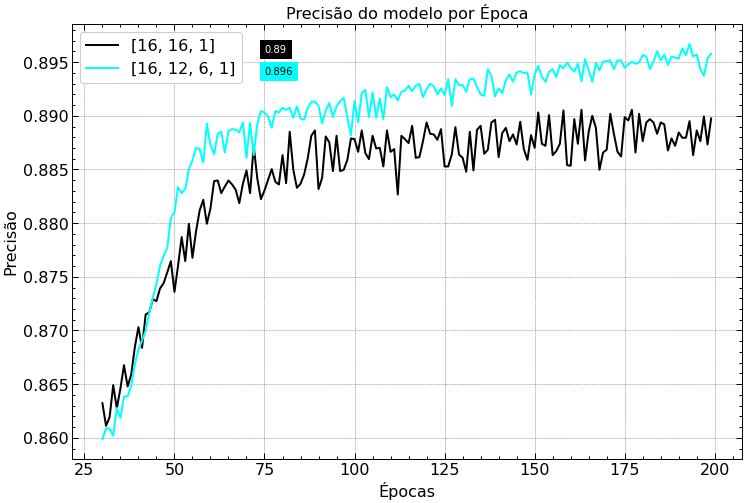

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title('Precisão do modelo por Época')
ax.set_ylabel('Precisão')
ax.set_xlabel('Épocas')


# ax.legend(['', 'val'], loc='upper left')
for index, history in enumerate(final_history):
  # ax.plot(history.history['val_loss'])
  text = str(
      round(history.history['val_accuracy'][-1], 3)
  )
  ax.plot(history.epoch[30:], history.history['val_accuracy'][30:], color=colors[index])
  ax.text(75, 0.8959 - index/500, text, backgroundcolor=colors[index], color=text_colors[index])

ax.legend([str([16,16,1]), str([16,12,6,1])])
# ax.legend(legend)
plt.plot()
fig.savefig('/content/cross_validation_accuracy_zoom_final.png')

# fig, ax = plt.subplots(1,1, figsize=(12,8))
# ax.set_title('Precisão do modelo por Época')
# ax.set_ylabel('Precisão')
# ax.set_xlabel('Épocas')

# # ax.legend(['', 'val'], loc='upper left')
# for index, history in enumerate(final_history):
#   # ax.plot(history.history['val_loss'])
#   text = str(
#       round(history.history['accuracy'][-1], 3)
#   )
#   ax.plot(history.epoch[30:], history.history['val_accuracy'][30:], color=colors[index])
#   # ax.plot(history.epoch[30:], history.history['accuracy'][30:], '--', color=colors[index], lw=0.5)
#   ax.text(75, 0.8919 - index/500, text, backgroundcolor=colors[index], color=text_colors[index])

# ax.legend([str([16,16,1]), str([16,12,6,1])])
# # ax.legend(legend)
# plt.plot()
# fig.savefig('/content/cross_validation_accuracy_zoom_final_train.png')

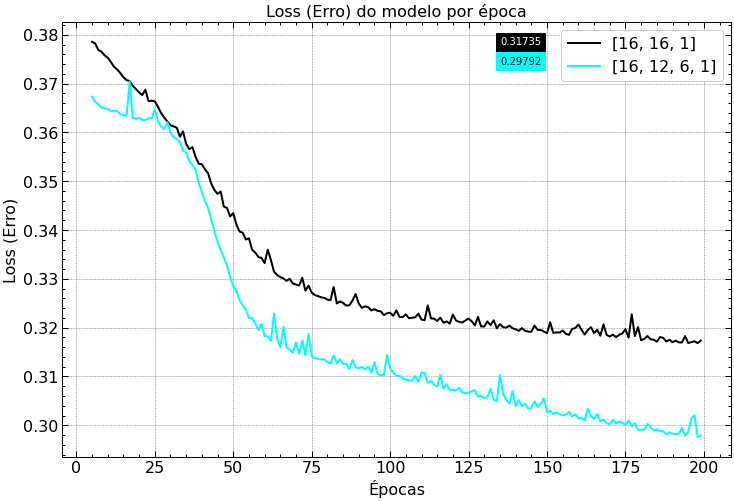

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title('Loss (Erro) do modelo por época')
ax.set_ylabel('Loss (Erro)')
ax.set_xlabel('Épocas')


# ax.legend(['', 'val'], loc='upper left')
for index, history in enumerate(final_history):
  # ax.plot(history.history['val_loss'])
  text = str(round(history.history['val_loss'][-1], 5))
  ax.plot(history.epoch[5:], history.history['val_loss'][5:], color=colors[index])
  ax.text(135, 0.378-index/250, text, backgroundcolor=colors[index], color=text_colors[index])

ax.legend([str([16,16,1]), str([16,12,6,1])])
# ax.legend(legend)
plt.plot()
fig.savefig('/content/cross_validation_loss_zoom_final.png')


# fig, ax = plt.subplots(1,1, figsize=(12,8))
# ax.set_title('Loss (Erro) do modelo por época')
# ax.set_ylabel('Loss (Erro)')
# ax.set_xlabel('Épocas')


# # ax.legend(['', 'val'], loc='upper left')
# for index, history in enumerate(final_history):
#   # ax.plot(history.history['val_loss'])
#   text = str(round(history.history['loss'][-1], 5))
#   ax.plot(history.epoch[5:], history.history['loss'][5:], color=colors[index])
#   ax.text(135, 0.378-index/250, text, backgroundcolor=colors[index], color=text_colors[index])

# ax.legend([str([16,8,4,1]), str([16,12,6,1])])
# # ax.legend(legend)
# plt.plot()
# fig.savefig('/content/cross_validation_loss_zoom_final_train.png')

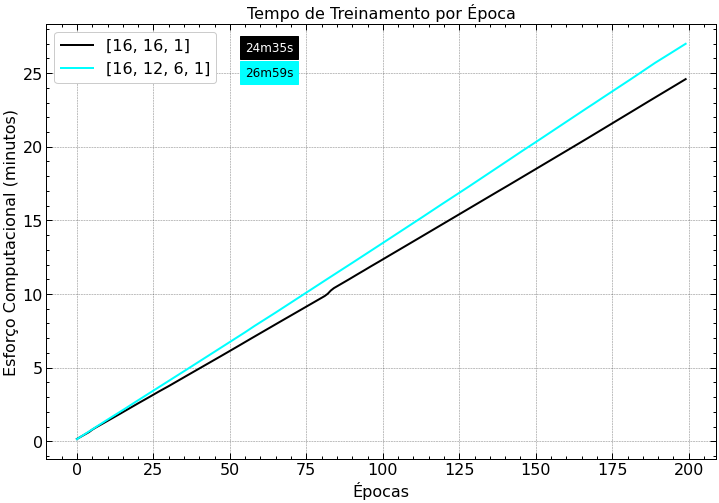

In [ ]:
def seconds_to_minutes_seconds(seconds: int):
  minutes = seconds//60
  sec = seconds % 60

  return int(minutes), int(sec)


fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title('Tempo de Treinamento por Época')
ax.set_ylabel('Esforço Computacional (minutos)')
ax.set_xlabel('Épocas')

# ax.legend(['', 'val'], loc='upper left')
for index, history in enumerate(final_history):
  # ax.plot(history.history['val_loss'])
  min, secs = seconds_to_minutes_seconds(sum(final_computational_effort[index].logs))
  text = f'{min}m{secs}s'
  cumsum = [sum(final_computational_effort[index].logs[:i+1]) for i in range(len(final_computational_effort[index].logs))]
  cumsum = [i/60 for i in cumsum]
  ax.plot(history.epoch, cumsum, color=colors[index])
  ax.text(55, 26.5-1.7*index, text, backgroundcolor=colors[index], color=text_colors[index], fontsize='large')

ax.legend([str([16,16,1]), str([16,12,6,1])])
# ax.legend(legend)
plt.plot()
fig.savefig('/content/cross_validation_computational_effort_final.png')

In [ ]:
z

# Gráfico da variável de saída

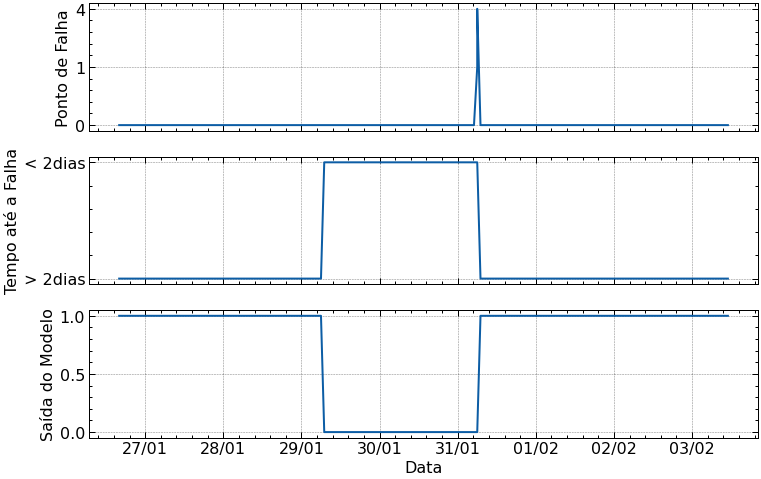

In [ ]:
fDate = DateFormatter('%d/%m')
pseudo_data = data.query('machineID == 33')[610:800]
value_encoder = {'< 2dias': 0, '> 2dias': 1}
pseudo_data['2dias_binary'] = pseudo_data['2dias'].apply(lambda row: value_encoder[row])

fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True)
# fig.suptitle('Comportamento da Variável de Saída')
ax[0].set_ylabel('Ponto de Falha')
ax[1].set_ylabel('Tempo até a Falha')
ax[2].set_ylabel('Saída do Modelo')
ax[0].xaxis.set_major_formatter(fDate)
ax[1].xaxis.set_major_formatter(fDate)
ax[2].xaxis.set_major_formatter(fDate)
ax[2].set_xlabel('Data')

ax[0].plot(pseudo_data.datetime, pseudo_data.failure)
ax[1].plot(pseudo_data.datetime, pseudo_data['2dias'])
ax[2].plot(pseudo_data.datetime, pseudo_data['2dias_binary'])

fig.savefig('/content/output_sample.png')

# Persistência dos modelos treinados

In [ ]:
names=['06122021_16_16_1', '06122021_16_12_6_1']
for index, model in enumerate(final_models):
  model.save(f'/content/drive/MyDrive/Colab Data/Modelos/{names[index]}')
  

NameError: ignored

# Leitura dos modelos

In [ ]:
names=['06122021_16_16_1', '06122021_16_12_6_1']
final_models = []
for name in names:
  final_models.append(keras.models.load_model(f'/content/drive/MyDrive/Colab Data/Modelos/{name}'))

# CONFUSION MATRIX

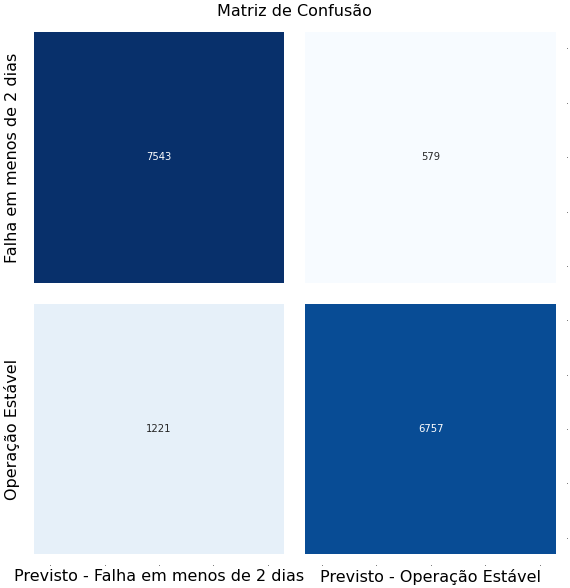

In [ ]:
y_pred = final_models[0].predict(x_test_list[0])
y_pred = np.where(y_pred > 0.58, 1, 0)
y_pred = encoder_list[0].inverse_transform(y_pred.reshape(y_pred.shape[0],))
y_test = encoder_list[0].inverse_transform(y_test_list[0])

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
plt.title("Matriz de Confusão")
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    yticklabels=['Falha em menos de 2 dias', 'Operação Estável'],
    xticklabels=['Previsto - Falha em menos de 2 dias', 'Previsto - Operação Estável'],
    cmap="Blues",
    cbar=False,
    robust=True,  
    square=True,
    linewidths=20,
    linecolor='White'
)

In [ ]:
d = {}
sum_errors = []
sum_correct = []
fail_correct = []
stable_correct = []
vals = []
for i in range(20, 80, 2):
  y_pred = final_models[0].predict(x_test_list[0])
  y_pred = np.where(y_pred > i/100, 1, 0)
  y_pred = encoder_list[0].inverse_transform(y_pred.reshape(y_pred.shape[0],))
  y_test = encoder_list[0].inverse_transform(y_test_list[0])
  conf_mat = confusion_matrix(y_test, y_pred)

  vals.append(i/100)
  stable_correct.append(conf_mat[1][1])
  sum_errors.append(sum([conf_mat[0][1], conf_mat[1][0]]))
  sum_correct.append(sum([conf_mat[0][0], conf_mat[1][1]]))
  fail_correct.append(conf_mat[0][0])
  
  d[f'{i/100}'] = [sum([conf_mat[0][1], conf_mat[1][0]]), abs(conf_mat[0][1]-conf_mat[1][0]), conf_mat[0][0], conf_mat[0][0]+conf_mat[1][1]]


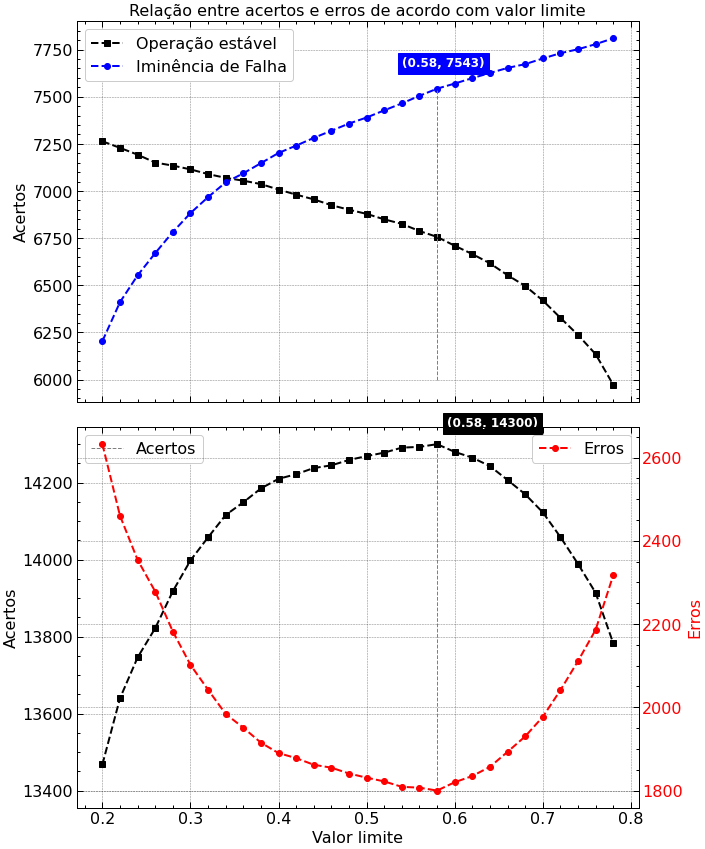

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10, 12), sharex=True)
ax[0].set_title('Relação entre acertos e erros de acordo com valor limite')
ax[0].set_ylabel('Acertos')
ax[1].set_ylabel('Acertos')
ax[1].set_xlabel('Valor limite')
ax[1].tick_params(axis='y', labelcolor='black')
ax2 = ax[1].twinx()

# ax.legend(['', 'val'], loc='upper left')
# ax.plot(history.history['val_loss'])
ax[0].plot(vals, stable_correct, '--s', color='black')
ax[0].plot(vals, fail_correct, linestyle='--', marker='o', color='blue')
ax[0].plot([0.58]*len(fail_correct), [6000] + [7543]*(len(fail_correct)-1), '--', color='grey', lw=1)
ax[1].plot([0.58]*len(fail_correct), [13400] + [14300]*(len(fail_correct)-1), '--', color='grey', lw=1)
ax[0].legend(['Operação estável', 'Iminência de Falha'])
ax[1].plot(vals, sum_correct, '--s', color='black')
ax[1].legend(['Acertos'], loc='upper left')

ax2.plot(vals, sum_errors, linestyle='--', marker='o', color='red')
ax2.set_ylabel('Erros', color='red')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(['Erros'])
anot_txt = max(sum_correct)
x_anot = vals[sum_correct.index(max(sum_correct))]

ax[1].annotate(f'({x_anot}, {anot_txt})', xy=(x_anot, anot_txt), xytext=(10,17.5), textcoords='offset points', size='large', fontweight=800, backgroundcolor='black', color='white')

y_anot = fail_correct[vals.index(x_anot)]
ax[0].annotate(f'({x_anot}, {y_anot})', xy=(x_anot, y_anot), xytext=(-35,22), textcoords='offset points', size='large', fontweight=800, backgroundcolor='blue', color='white')

# ax.text(75, 0.8959 - index/500, text, backgroundcolor=colors[index], color=text_colors[index])

# ax.set_legend([str([16,16,1]), str([16,12,6,1])])
# ax.legend(legend)
fig.tight_layout()
plt.plot()
fig.savefig('/content/metricas_pre_pos_process.png')


In [ ]:
stable_correct

# Simulação temporal aplicada da máquina 100

In [ ]:
default_sim_machines = sim_machines
filter = (sim_machines['2dias'] == '> 2dias')
sim_machines_filtered = sim_machines[filter]


for col in ['vibration', 'rotate', 'volt', 'pressure']:
  Q1 = sim_machines_filtered[col].quantile(0.25)
  Q3 = sim_machines_filtered[col].quantile(0.75)
  IQR = Q3 - Q1

  filter_col = (sim_machines_filtered[col] >= Q1 - IQR) & (sim_machines_filtered[col] <= Q3 + IQR)
  sim_machines_filtered = sim_machines_filtered[filter_col]

sim_machines = sim_machines_filtered.append(sim_machines[sim_machines['2dias'] == '< 2dias'])
sim_machines = sim_machines.sort_values(by='datetime')



In [ ]:
# data = all_data['all_data']
features_cols = ['volt', 'vibration', 'rotate', 'pressure']
sim_machines_2dias = sim_machines['2dias']
sim_machines = sim_machines.drop(columns=['2dias'])
sim_machines['2dias'] = sim_machines_2dias
machine_100 = sim_machines[sim_machines.machineID == 100]
machine_99 = sim_machines[sim_machines.machineID == 99]
machine_98 = sim_machines[sim_machines.machineID == 98]
machine_97 = sim_machines[sim_machines.machineID == 97]
machine_96 = sim_machines[sim_machines.machineID == 96]
# machine_100.columns
remove_cols = ['datetime', 'errorID', 'failure', 'machineID', '30dias', '15dias', '7dias', '4dias']

temp_data = machine_100.drop(columns = remove_cols+features_cols).dropna().to_numpy()
temp_data99 = machine_99.drop(columns = remove_cols+features_cols).dropna().to_numpy()
temp_data98 = machine_98.drop(columns = remove_cols+features_cols).dropna().to_numpy()
temp_data97 = machine_97.drop(columns = remove_cols+features_cols).dropna().to_numpy()
temp_data96 = machine_96.drop(columns = remove_cols+features_cols).dropna().to_numpy()

# temp_data = machine_100.drop(columns = remove_cols).dropna().to_numpy()

scaler = scaler_list[0]
le = LabelEncoder()
# pré-processamento


# Dados de entrada
# scaler.fit(temp_data[:, :-1])
temp_scaled_data = scaler.transform(temp_data[:, :-1])
temp_scaled_data99 = scaler.transform(temp_data99[:, :-1])
temp_scaled_data98 = scaler.transform(temp_data98[:, :-1])
temp_scaled_data97 = scaler.transform(temp_data97[:, :-1])
temp_scaled_data96 = scaler.transform(temp_data96[:, :-1])

x_test = temp_scaled_data
x_test99 = temp_scaled_data99
x_test98 = temp_scaled_data98
x_test97 = temp_scaled_data97
x_test96 = temp_scaled_data96

# Dados de saída
le.fit(temp_data[:, -1])
le.fit(temp_data99[:, -1])
le.fit(temp_data98[:, -1])
le.fit(temp_data97[:, -1])
le.fit(temp_data96[:, -1])


y_test = le.transform(temp_data[:, -1])
y_test99 = le.transform(temp_data99[:, -1])
y_test98 = le.transform(temp_data98[:, -1])
y_test97 = le.transform(temp_data97[:, -1])
y_test96 = le.transform(temp_data96[:, -1])
# x_test

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

cmap = LinearSegmentedColormap.from_list('mycmap', ['green', 'yellow', 'orange', 'red'])

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

## Máquina 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


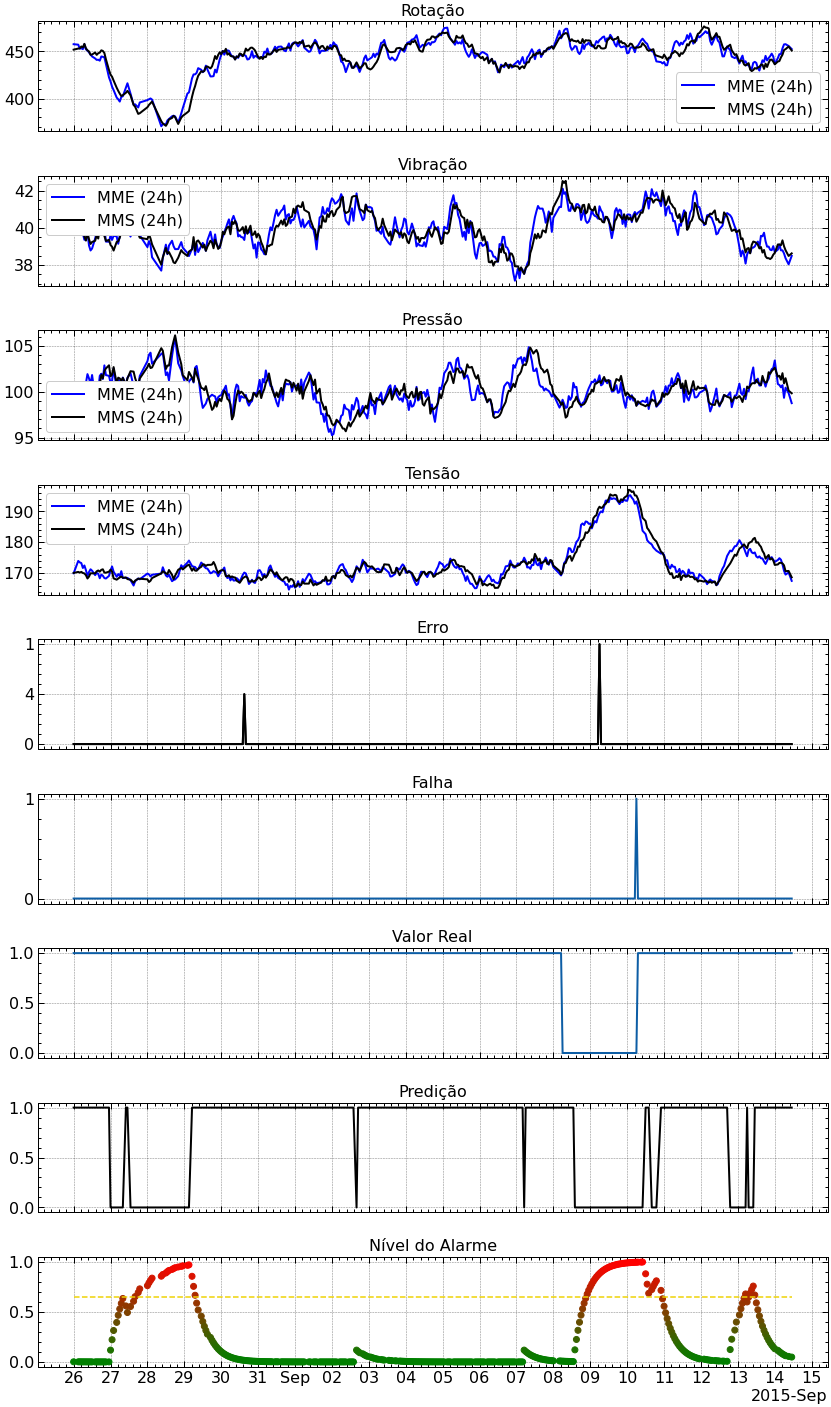

In [ ]:
# date_format = DateFormatter('%d/%m - %Hh')
# prediction = model.predict(x_test)
prediction = final_models[0].predict(x_test)
prediction = np.where(prediction > 0.58, 1, 0)
# prediction = np.where(prediction > 0.5, 1, prediction)
# prediction = np.where(prediction < 0.2, 0, np.where(prediction <= 0.5, 0.5, prediction))
machine_100['prediction'] = prediction
machine_100['prediction_perc'] = (1 - machine_100['prediction'].ewm(span=16).mean())
# graph_start = 0
# graph_end = len(machine_100)
graph_start = -2550
graph_end = -2150
machine_100_50 = machine_100[graph_start:graph_end]

fig, ax = plt.subplots(9, 1, figsize=(12, 20), sharex='col', sharey='row')
for i in range(0, 9):
  # ax[i].xaxis.set_major_formatter(date_format)
  # ax[i].xaxis.set_minor_locator(HourLocator(interval=20))
  ax[i].xaxis.set_major_locator(DayLocator())
  # ax[i].xaxis.set_minor_formatter(ConciseDateFormatter(ax[i].xaxis.get_minor_locator()))
  ax[i].xaxis.set_major_formatter(ConciseDateFormatter(ax[i].xaxis.get_major_locator()))



# Primeira Linha
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_ewma24h, color='blue')
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_mean24h, color='black')

ax[0].set_title('Rotação')


# Segunda Linha
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_ewma24h, color='blue')
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_mean24h, color='black')
ax[1].set_title('Vibração')


# Terceira Linha
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_ewma24h, color='blue')
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_mean24h, color='black')
ax[2].set_title('Pressão')


# Quarta Linha
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_ewma24h, color='blue')
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_mean24h, color='black')
ax[3].set_title('Tensão')


# Quinta Linha
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].set_title('Erro')

# Sexta Linha
ax[5].plot(machine_100_50.datetime, machine_100_50.failure)
ax[5].set_title('Falha')

# Sétima Linha
ax[6].plot(machine_100_50.datetime, le.transform(machine_100_50['2dias']))
ax[6].set_title('Valor Real')

# Sétima Linha
ax[7].plot(machine_100_50.datetime, prediction[graph_start:graph_end], color='black')
ax[7].set_title('Predição')

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('green'), c('red')])
colors = machine_100_50.prediction_perc
# Sétima Linha

ax[8].scatter(machine_100_50.datetime,  machine_100_50.prediction_perc, c=colors, cmap=rvb)
ax[8].plot(machine_100_50.datetime, [0.65]*len(machine_100_50.datetime), '--', lw=1.5, color='#EED202')
ax[8].set_title('Nível do Alarme')

for i in range(0, 4):
  ax[i].legend(['MME (24h)', 'MMS (24h)'])


fig.tight_layout(pad=2.0)
fig.savefig('final_simulation_zoom.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


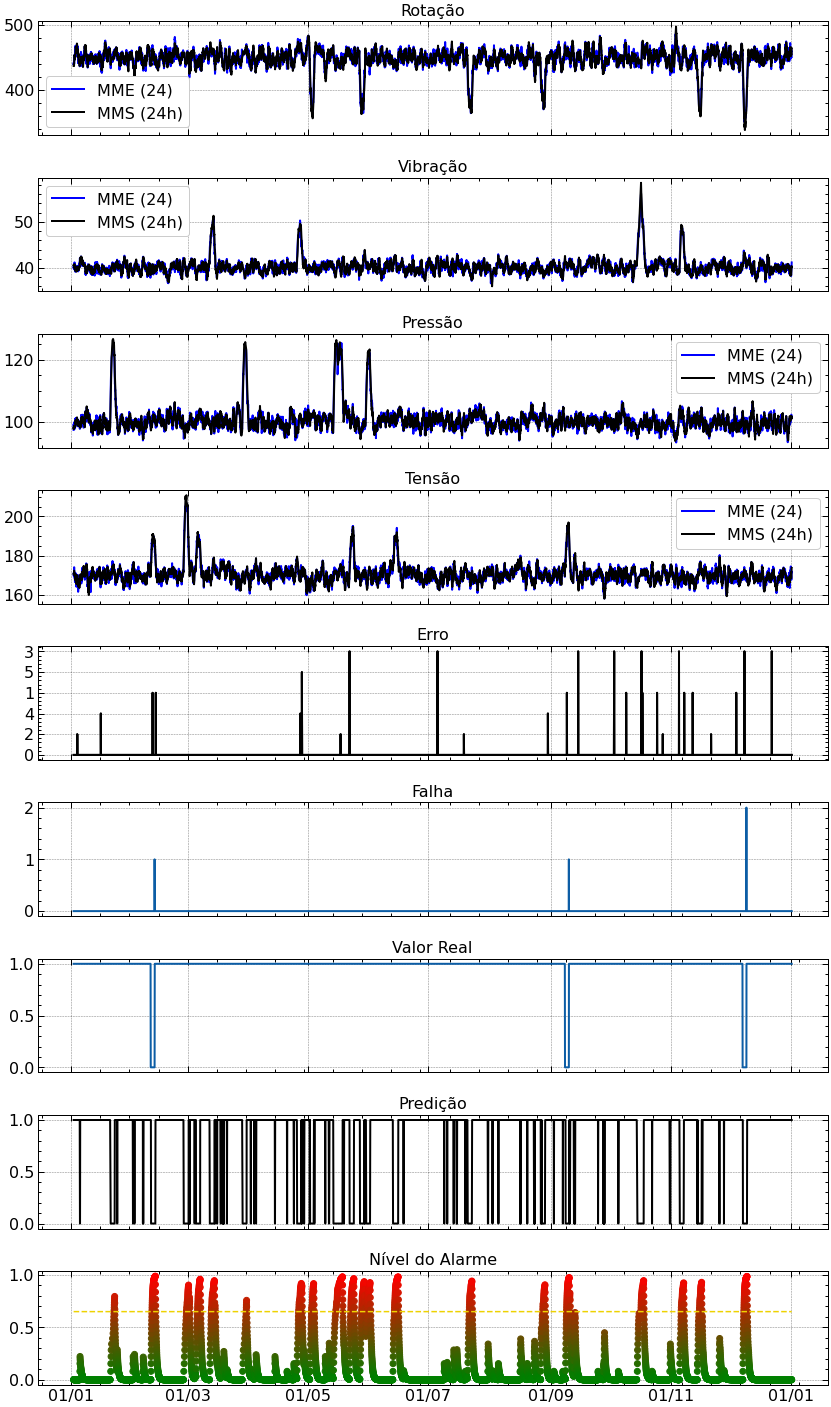

In [ ]:
date_format = DateFormatter('%d/%m')
# prediction = model.predict(x_test)
prediction = final_models[0].predict(x_test)
prediction = np.where(prediction > 0.58, 1, 0)
# prediction = np.where(prediction > 0.5, 1, prediction)
# prediction = np.where(prediction < 0.2, 0, np.where(prediction <= 0.5, 0.5, prediction))
machine_100['prediction'] = prediction
machine_100['prediction_perc'] = (1 - machine_100['prediction'].ewm(span=24).mean())
graph_start = 0
graph_end = len(machine_100)
machine_100_50 = machine_100[graph_start:graph_end]

fig, ax = plt.subplots(9, 1, figsize=(12, 20), sharex='col', sharey='row')
for i in range(0, 9):
  ax[i].xaxis.set_major_formatter(date_format)
  # ax[i].xaxis.set_minor_locator(HourLocator(interval=20))
  # ax[i].xaxis.set_major_locator(DayLocator())
  # ax[i].xaxis.set_minor_formatter(ConciseDateFormatter(ax[i].xaxis.get_minor_locator()))
  # ax[i].xaxis.set_major_formatter(ConciseDateFormatter(ax[i].xaxis.get_major_locator()))



# Primeira Linha
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_ewma24h, color='blue')
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_mean24h, color='black')

ax[0].set_title('Rotação')


# Segunda Linha
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_ewma24h, color='blue')
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_mean24h, color='black')
ax[1].set_title('Vibração')


# Terceira Linha
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_ewma24h, color='blue')
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_mean24h, color='black')
ax[2].set_title('Pressão')


# Quarta Linha
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_ewma24h, color='blue')
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_mean24h, color='black')
ax[3].set_title('Tensão')


# Quinta Linha
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].set_title('Erro')

# Sexta Linha
ax[5].plot(machine_100_50.datetime, machine_100_50.failure)
ax[5].set_title('Falha')

# Sétima Linha
ax[6].plot(machine_100_50.datetime, le.transform(machine_100_50['2dias']))
ax[6].set_title('Valor Real')

# Sétima Linha
ax[7].plot(machine_100_50.datetime, prediction[graph_start:graph_end], color='black')
ax[7].set_title('Predição')

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('green'), c('red')])
colors = machine_100_50.prediction_perc
# Sétima Linha

ax[8].scatter(machine_100_50.datetime,  machine_100_50.prediction_perc, c=colors, cmap=rvb)
ax[8].plot(machine_100_50.datetime, [0.65]*len(machine_100_50.datetime), '--', lw=1.5, color='#EED202')
ax[8].set_title('Nível do Alarme')

for i in range(0, 4):
  ax[i].legend(['MME (24)', 'MMS (24h)'])


fig.tight_layout(pad=2.0)
fig.savefig('final_simulation.png')

## Máquina 99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


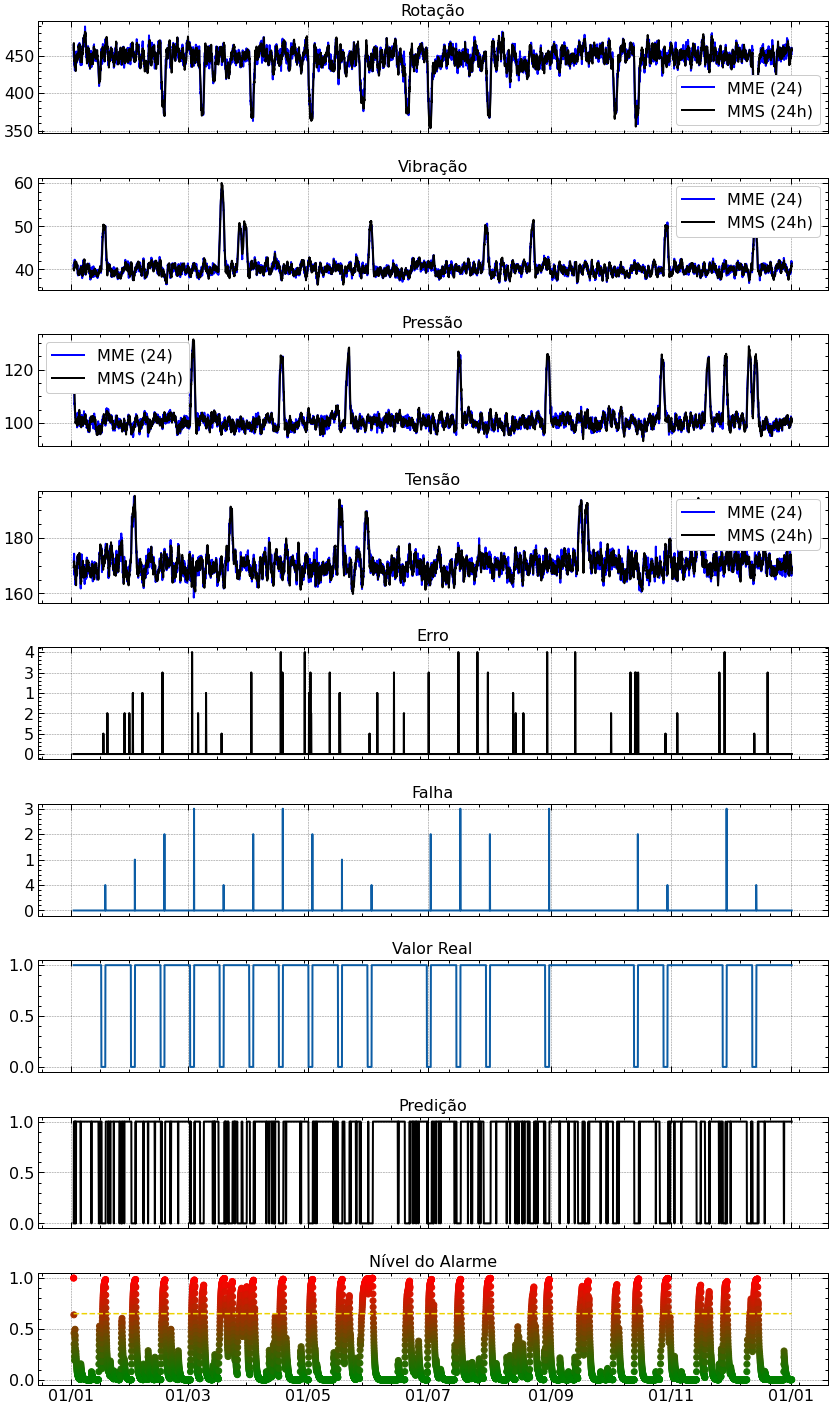

In [ ]:
date_format = DateFormatter('%d/%m')
# prediction = model.predict(x_test)
prediction = final_models[0].predict(x_test99)
prediction = np.where(prediction > 0.58, 1, 0)
# prediction = np.where(prediction > 0.5, 1, prediction)
# prediction = np.where(prediction < 0.2, 0, np.where(prediction <= 0.5, 0.5, prediction))
machine_99['prediction'] = prediction
machine_99['prediction_perc'] = (1 - machine_99['prediction'].ewm(span=24).mean())
graph_start = 0
graph_end = len(machine_99)
machine_100_50 = machine_99[graph_start:graph_end]

fig, ax = plt.subplots(9, 1, figsize=(12, 20), sharex='col', sharey='row')
for i in range(0, 9):
  ax[i].xaxis.set_major_formatter(date_format)
  # ax[i].xaxis.set_minor_locator(HourLocator(interval=20))
  # ax[i].xaxis.set_major_locator(DayLocator())
  # ax[i].xaxis.set_minor_formatter(ConciseDateFormatter(ax[i].xaxis.get_minor_locator()))
  # ax[i].xaxis.set_major_formatter(ConciseDateFormatter(ax[i].xaxis.get_major_locator()))



# Primeira Linha
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_ewma24h, color='blue')
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_mean24h, color='black')

ax[0].set_title('Rotação')


# Segunda Linha
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_ewma24h, color='blue')
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_mean24h, color='black')
ax[1].set_title('Vibração')


# Terceira Linha
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_ewma24h, color='blue')
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_mean24h, color='black')
ax[2].set_title('Pressão')


# Quarta Linha
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_ewma24h, color='blue')
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_mean24h, color='black')
ax[3].set_title('Tensão')


# Quinta Linha
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].set_title('Erro')

# Sexta Linha
ax[5].plot(machine_100_50.datetime, machine_100_50.failure)
ax[5].set_title('Falha')

# Sétima Linha
ax[6].plot(machine_100_50.datetime, le.transform(machine_100_50['2dias']))
ax[6].set_title('Valor Real')

# Sétima Linha
ax[7].plot(machine_100_50.datetime, prediction[graph_start:graph_end], color='black')
ax[7].set_title('Predição')

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('green'), c('red')])
colors = machine_100_50.prediction_perc
# Sétima Linha

ax[8].scatter(machine_100_50.datetime,  machine_100_50.prediction_perc, c=colors, cmap=rvb)
ax[8].plot(machine_100_50.datetime, [0.65]*len(machine_100_50.datetime), '--', lw=1.5, color='#EED202')
ax[8].set_title('Nível do Alarme')

for i in range(0, 4):
  ax[i].legend(['MME (24)', 'MMS (24h)'])


fig.tight_layout(pad=2.0)
fig.savefig('final_simulation.png')

## Máquina 98

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


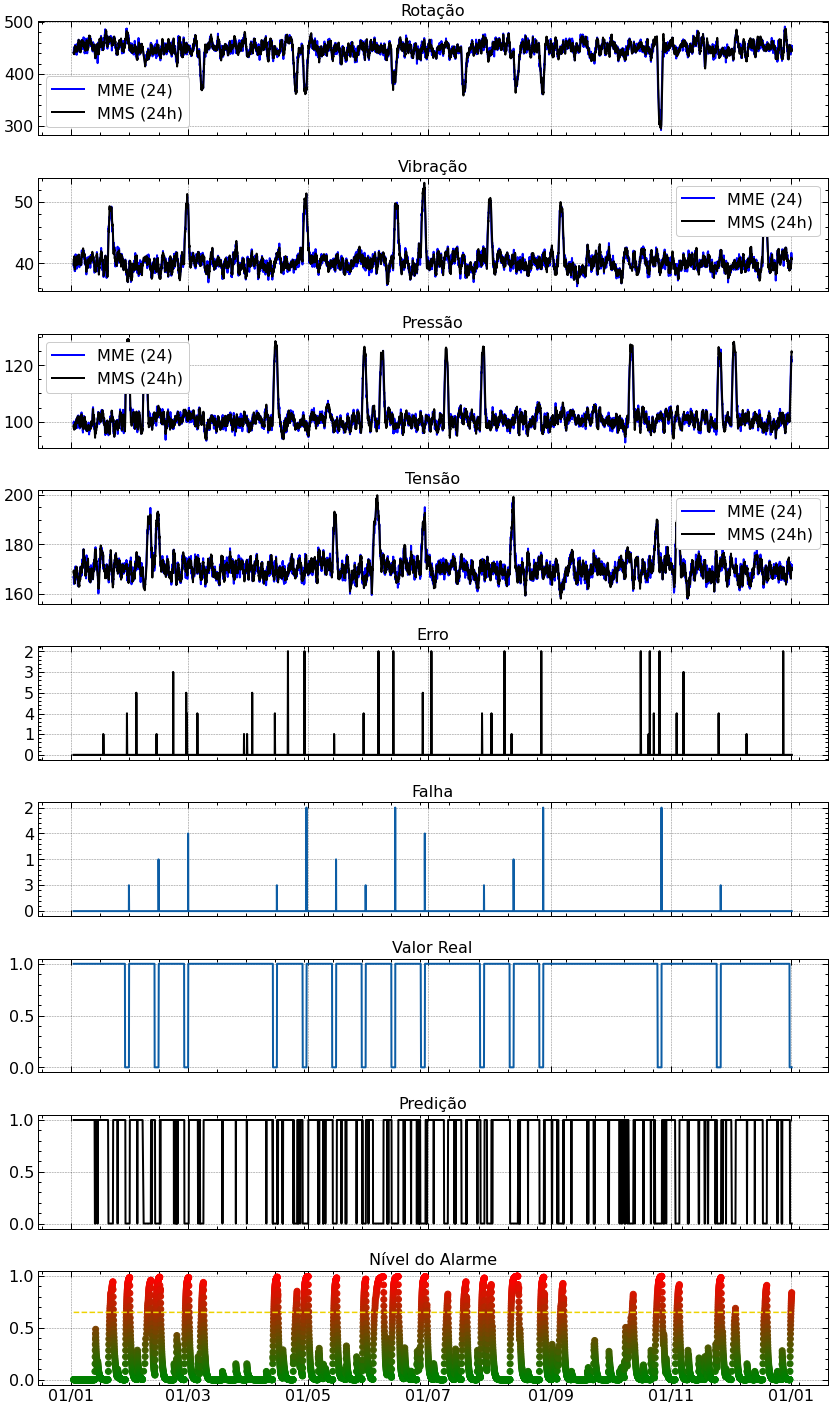

In [ ]:
date_format = DateFormatter('%d/%m')
# prediction = model.predict(x_test)
prediction = final_models[0].predict(x_test98)
prediction = np.where(prediction > 0.58, 1, 0)
# prediction = np.where(prediction > 0.5, 1, prediction)
# prediction = np.where(prediction < 0.2, 0, np.where(prediction <= 0.5, 0.5, prediction))
machine_98['prediction'] = prediction
machine_98['prediction_perc'] = (1 - machine_98['prediction'].ewm(span=24).mean())
graph_start = 0
graph_end = len(machine_98)
machine_100_50 = machine_98[graph_start:graph_end]

fig, ax = plt.subplots(9, 1, figsize=(12, 20), sharex='col', sharey='row')
for i in range(0, 9):
  ax[i].xaxis.set_major_formatter(date_format)
  # ax[i].xaxis.set_minor_locator(HourLocator(interval=20))
  # ax[i].xaxis.set_major_locator(DayLocator())
  # ax[i].xaxis.set_minor_formatter(ConciseDateFormatter(ax[i].xaxis.get_minor_locator()))
  # ax[i].xaxis.set_major_formatter(ConciseDateFormatter(ax[i].xaxis.get_major_locator()))



# Primeira Linha
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_ewma24h, color='blue')
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_mean24h, color='black')

ax[0].set_title('Rotação')


# Segunda Linha
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_ewma24h, color='blue')
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_mean24h, color='black')
ax[1].set_title('Vibração')


# Terceira Linha
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_ewma24h, color='blue')
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_mean24h, color='black')
ax[2].set_title('Pressão')


# Quarta Linha
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_ewma24h, color='blue')
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_mean24h, color='black')
ax[3].set_title('Tensão')


# Quinta Linha
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].set_title('Erro')

# Sexta Linha
ax[5].plot(machine_100_50.datetime, machine_100_50.failure)
ax[5].set_title('Falha')

# Sétima Linha
ax[6].plot(machine_100_50.datetime, le.transform(machine_100_50['2dias']))
ax[6].set_title('Valor Real')

# Sétima Linha
ax[7].plot(machine_100_50.datetime, prediction[graph_start:graph_end], color='black')
ax[7].set_title('Predição')

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('green'), c('red')])
colors = machine_100_50.prediction_perc
# Sétima Linha

ax[8].scatter(machine_100_50.datetime,  machine_100_50.prediction_perc, c=colors, cmap=rvb)
ax[8].plot(machine_100_50.datetime, [0.65]*len(machine_100_50.datetime), '--', lw=1.5, color='#EED202')
ax[8].set_title('Nível do Alarme')

for i in range(0, 4):
  ax[i].legend(['MME (24)', 'MMS (24h)'])


fig.tight_layout(pad=2.0)
fig.savefig('final_simulation.png')

## Máquina 97

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


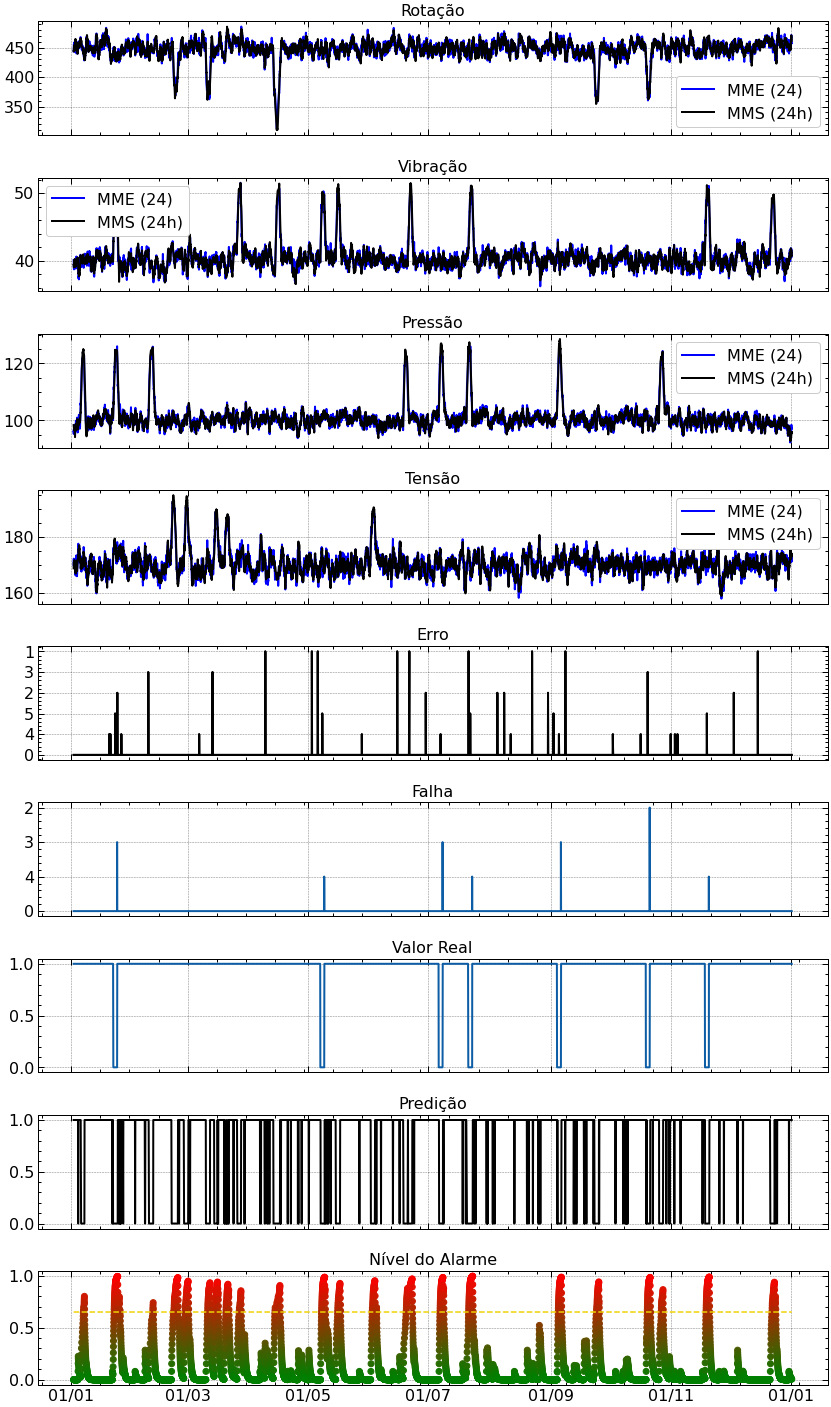

In [ ]:
date_format = DateFormatter('%d/%m')
# prediction = model.predict(x_test)
prediction = final_models[0].predict(x_test97)
prediction = np.where(prediction > 0.58, 1, 0)
# prediction = np.where(prediction > 0.5, 1, prediction)
# prediction = np.where(prediction < 0.2, 0, np.where(prediction <= 0.5, 0.5, prediction))
machine_97['prediction'] = prediction
machine_97['prediction_perc'] = (1 - machine_97['prediction'].ewm(span=24).mean())
graph_start = 0
graph_end = len(machine_97)
machine_100_50 = machine_97[graph_start:graph_end]

fig, ax = plt.subplots(9, 1, figsize=(12, 20), sharex='col', sharey='row')
for i in range(0, 9):
  ax[i].xaxis.set_major_formatter(date_format)
  # ax[i].xaxis.set_minor_locator(HourLocator(interval=20))
  # ax[i].xaxis.set_major_locator(DayLocator())
  # ax[i].xaxis.set_minor_formatter(ConciseDateFormatter(ax[i].xaxis.get_minor_locator()))
  # ax[i].xaxis.set_major_formatter(ConciseDateFormatter(ax[i].xaxis.get_major_locator()))



# Primeira Linha
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_ewma24h, color='blue')
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_mean24h, color='black')

ax[0].set_title('Rotação')


# Segunda Linha
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_ewma24h, color='blue')
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_mean24h, color='black')
ax[1].set_title('Vibração')


# Terceira Linha
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_ewma24h, color='blue')
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_mean24h, color='black')
ax[2].set_title('Pressão')


# Quarta Linha
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_ewma24h, color='blue')
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_mean24h, color='black')
ax[3].set_title('Tensão')


# Quinta Linha
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].set_title('Erro')

# Sexta Linha
ax[5].plot(machine_100_50.datetime, machine_100_50.failure)
ax[5].set_title('Falha')

# Sétima Linha
ax[6].plot(machine_100_50.datetime, le.transform(machine_100_50['2dias']))
ax[6].set_title('Valor Real')

# Sétima Linha
ax[7].plot(machine_100_50.datetime, prediction[graph_start:graph_end], color='black')
ax[7].set_title('Predição')

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('green'), c('red')])
colors = machine_100_50.prediction_perc
# Sétima Linha

ax[8].scatter(machine_100_50.datetime,  machine_100_50.prediction_perc, c=colors, cmap=rvb)
ax[8].plot(machine_100_50.datetime, [0.65]*len(machine_100_50.datetime), '--', lw=1.5, color='#EED202')
ax[8].set_title('Nível do Alarme')

for i in range(0, 4):
  ax[i].legend(['MME (24)', 'MMS (24h)'])


fig.tight_layout(pad=2.0)
fig.savefig('final_simulation.png')

## Máquina 96

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


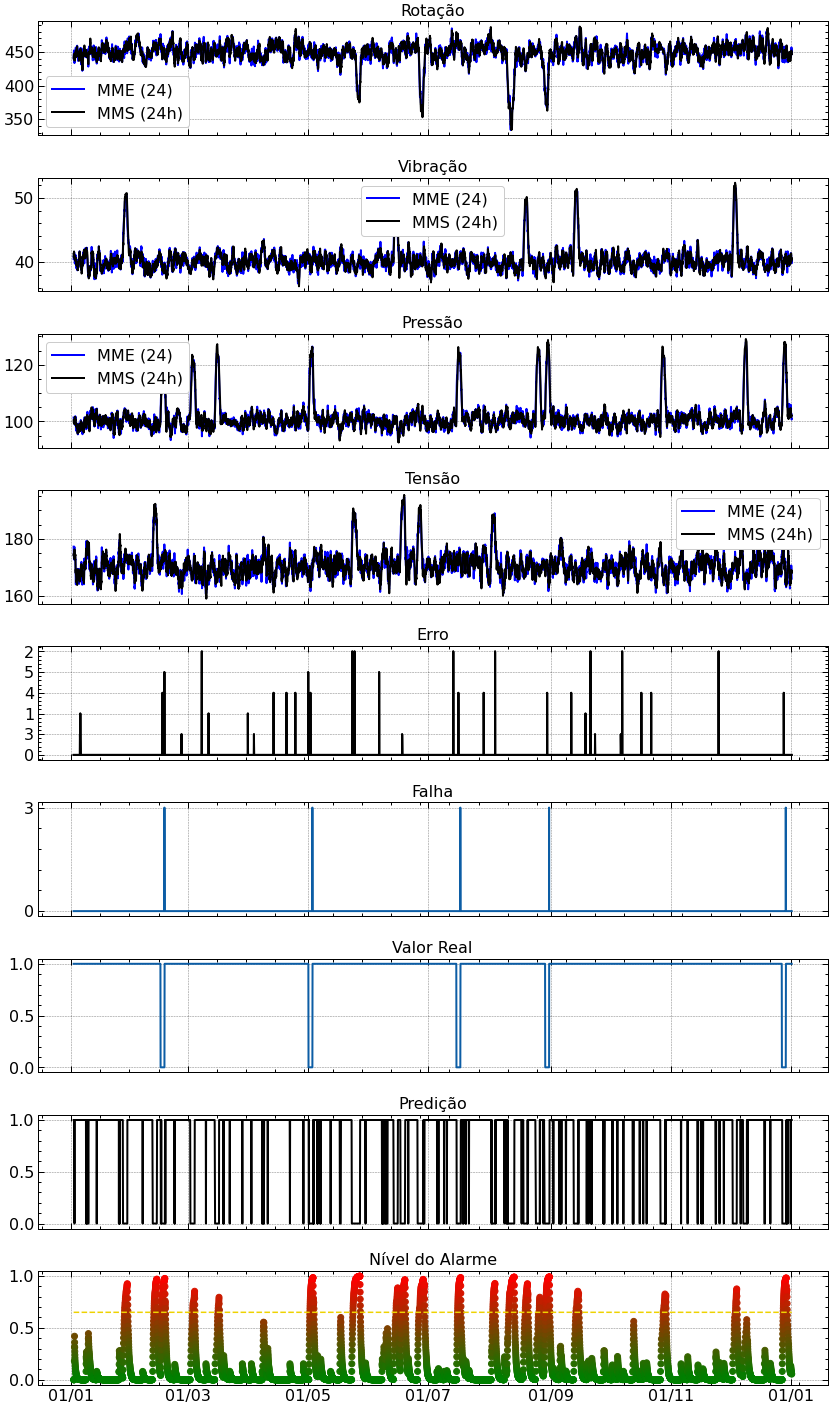

In [ ]:
date_format = DateFormatter('%d/%m')
# prediction = model.predict(x_test)
prediction = final_models[0].predict(x_test96)
prediction = np.where(prediction > 0.58, 1, 0)
# prediction = np.where(prediction > 0.5, 1, prediction)
# prediction = np.where(prediction < 0.2, 0, np.where(prediction <= 0.5, 0.5, prediction))
machine_96['prediction'] = prediction
machine_96['prediction_perc'] = (1 - machine_96['prediction'].ewm(span=24).mean())
graph_start = 0
graph_end = len(machine_96)
machine_100_50 = machine_96[graph_start:graph_end]

fig, ax = plt.subplots(9, 1, figsize=(12, 20), sharex='col', sharey='row')
for i in range(0, 9):
  ax[i].xaxis.set_major_formatter(date_format)
  # ax[i].xaxis.set_minor_locator(HourLocator(interval=20))
  # ax[i].xaxis.set_major_locator(DayLocator())
  # ax[i].xaxis.set_minor_formatter(ConciseDateFormatter(ax[i].xaxis.get_minor_locator()))
  # ax[i].xaxis.set_major_formatter(ConciseDateFormatter(ax[i].xaxis.get_major_locator()))



# Primeira Linha
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_ewma24h, color='blue')
ax[0].plot(machine_100_50.datetime, machine_100_50.rotate_mean24h, color='black')

ax[0].set_title('Rotação')


# Segunda Linha
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_ewma24h, color='blue')
ax[1].plot(machine_100_50.datetime, machine_100_50.vibration_mean24h, color='black')
ax[1].set_title('Vibração')


# Terceira Linha
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_ewma24h, color='blue')
ax[2].plot(machine_100_50.datetime, machine_100_50.pressure_mean24h, color='black')
ax[2].set_title('Pressão')


# Quarta Linha
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_ewma24h, color='blue')
ax[3].plot(machine_100_50.datetime, machine_100_50.volt_mean24h, color='black')
ax[3].set_title('Tensão')


# Quinta Linha
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].plot(machine_100_50.datetime, machine_100_50.errorID, color='black')
ax[4].set_title('Erro')

# Sexta Linha
ax[5].plot(machine_100_50.datetime, machine_100_50.failure)
ax[5].set_title('Falha')

# Sétima Linha
ax[6].plot(machine_100_50.datetime, le.transform(machine_100_50['2dias']))
ax[6].set_title('Valor Real')

# Sétima Linha
ax[7].plot(machine_100_50.datetime, prediction[graph_start:graph_end], color='black')
ax[7].set_title('Predição')

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('green'), c('red')])
colors = machine_100_50.prediction_perc
# Sétima Linha

ax[8].scatter(machine_100_50.datetime,  machine_100_50.prediction_perc, c=colors, cmap=rvb)
ax[8].plot(machine_100_50.datetime, [0.65]*len(machine_100_50.datetime), '--', lw=1.5, color='#EED202')
ax[8].set_title('Nível do Alarme')

for i in range(0, 4):
  ax[i].legend(['MME (24)', 'MMS (24h)'])


fig.tight_layout(pad=2.0)
fig.savefig('final_simulation.png')

# Teste da saída esperada

---

